# ROUGE Metric Implementation

## imports

In [1]:
import json
from collections import OrderedDict

import numpy as np

import torch
import torch.optim as optim
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from torch.utils.data import Dataset, DataLoader, random_split

# from models import BasicSummarizer
from types_ import *

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [3]:
DEVICE

device(type='cuda')

## data load

### 1) Sentence data

In [4]:
%%time

data_path = '../../data/summary/data/train.json'
with open(data_path, 'r', encoding='utf8') as f:
    data = [json.loads(line) for line in f]

Wall time: 4.29 s


In [5]:
sample1 = data[0]

text1 = sample1['doc']
summary1 = sample1['summaries']
labels1 = sample1['labels']
labels1 = labels1.split('\n')
labels1 = [int(label) for label in labels1]

sentences1 = text1.split('\n')

In [6]:
# sentences1

## dataloader

### 1) Summary Dataset

In [7]:
def generate_batch(batch):
    docs = [entry[0] for entry in batch]
    labels = [entry[1] for entry in batch]
    
    offsets = [0] + [len(doc) for doc in docs]
        
    return docs, offsets, labels

In [8]:
class SummaryDataset(Dataset):
    
    def __init__(self, path):
        
        with open(path, 'r', encoding='utf8') as f:
            self.data = [json.loads(line) for line in f]
        
    def __len__(self):
        """Returns the number of data."""
        return len(self.data)
    
    def __getitem__(self, idx):
        sentences = self.data[idx]['doc'].split('\n')
        labels = self.data[idx]['labels'].split('\n')
        labels = [int(label) for label in labels]
        
        return sentences, labels

### 2) dataset split (train, valid, test)

In [9]:
data_path = '../../data/summary/data/train.json'

dataset = SummaryDataset(data_path)

In [10]:
train_size = int(0.6 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size = len(dataset) - (train_size + valid_size)

train_dataset, valid_dataset, test_dataset \
    = random_split(dataset, [train_size, valid_size, test_size])

### 3) Dataloader for Summarizer

In [11]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=1, 
                              shuffle=False, 
                              collate_fn=generate_batch)

valid_dataloader = DataLoader(valid_dataset, 
                              batch_size=1, 
                              shuffle=False,
                              collate_fn=generate_batch)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=1, 
                             shuffle=False,
                             collate_fn=generate_batch)

In [12]:
batch = next(iter(train_dataloader))

In [13]:
docs, offsets, labels_list = batch

## loads trained model

In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split

import torch_geometric
from torch_geometric.nn import GATConv

from transformers import AlbertTokenizer, AlbertModel, AlbertConfig

from sklearn.metrics import pairwise_distances

INFO:transformers.file_utils:PyTorch version 1.4.0 available.


In [15]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")


class LSTM(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embed_dim=256,
                 hidden_dim=128,
                 num_layers=2,
                 bidirectional=True,
                 dropout=0.2):
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        if bidirectional:
            self.num_directs = 2
        else:
            self.num_directs = 1
        
        self.dropout = dropout
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, 
                              num_layers=num_layers,
                              batch_first=True, bidirectional=bidirectional)
        self.linear = nn.Linear(self.num_directs*hidden_dim, hidden_dim)
        
    
    def init_hidden(self, batch_size):
        # (num_layers * num_directions, batch_size, hidden_size)
        hidden = Variable(
            torch.zeros(self.num_layers*self.num_directs, batch_size, self.hidden_dim)
        )
        
        cell = Variable(
            torch.zeros(self.num_layers*self.num_directs, batch_size, self.hidden_dim)
        )
        return hidden, cell
        

    def forward(self, sents):
        x = self.embed(sents)
        
        h_0, cell = self.init_hidden(x.size(0))  # initial h_0
        h_0, cell = h_0.to(DEVICE), cell.to(DEVICE)

        # (batch, seq, feature)
        output, h_n = self.bilstm(x, (h_0, cell))
        output = torch.mean(output, dim=1)
        output = self.linear(output)
        return output


class GATClassifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads, num_classes=1):
        super().__init__()
        
        self.out_head = 1
        self.out_dim = out_dim
        
        self.conv1 = GATConv(in_dim, hidden_dim, heads=num_heads, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * num_heads, out_dim, concat=False,
                             heads=self.out_head, dropout=0.6)
        
        self.lstm = nn.LSTM(out_dim, 32, 1, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(32, num_classes)
        
    
    def init_hidden(self, batch_size):
        # (num_layers * num_directions, batch_size, hidden_size)
        hidden = Variable(torch.zeros(1, batch_size, 32), )
        cell = Variable(torch.zeros(1, batch_size, 32))
        return hidden, cell
    

    def forward(self, data):
        x, edge_index = data.x.to(DEVICE), data.edge_index.to(DEVICE)
        
        x = F.dropout(x, p=0.6, training=True)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=True)
        x = self.conv2(x, edge_index)
        x = x.view(-1, x.size(0), self.out_dim)
        
        h_0, cell = self.init_hidden(x.size(0))  # initial h_0
        h_0, cell = h_0.to(DEVICE), cell.to(DEVICE)
        output, h_n = self.lstm(x, (h_0, cell))
        
        # many-to-many
        output = self.fc(output)
        
        return output


In [74]:
class BasicSummarizer(nn.Module):
    
    def __init__(self, 
                 in_dim, 
                 hidden_dim, 
                 out_dim, 
                 num_heads, 
                 num_classes=2):
        super(BasicSummarizer, self).__init__()
        
        self.tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
        self.tokenizer.padding_side = 'left'
        self.embedder = LSTM(self.tokenizer.vocab_size)
        self.gat_classifier = GATClassifier(in_dim, hidden_dim, out_dim, num_heads, num_classes)

        
    def get_tokenize(self, docs):
        sent_tokens = [
            torch.cat(
                [self.tokenizer.encode(
                        sentences[i],
                        add_special_tokens=True,
                        max_length=128,
                        pad_to_max_length=True,
                        return_tensors='pt'
                 ) for i in range(len(sentences))]
            ) for sentences in docs
        ]

        sent_tokens = torch.cat([*sent_tokens])
        return sent_tokens
    
    def get_sentence_embedding(self, word_vecs, offsets):
        '''get node-featrues(setences embedding)'''
        features = []
        for idx in range(len(offsets) - 1):
            features.append(word_vecs[ offsets[idx]: offsets[idx]+offsets[idx+1] ])
        
        return features
    
    def build_graph(self, features_list, threshold=0.2):
        '''get edge_index for GATLayer'''
        edge_index_list = []
        for features in features_list:
            features = features.cpu()
            cosine_matrix = 1 - pairwise_distances(features.detach().numpy(), metric="cosine")
            adj_matrix = (cosine_matrix > threshold) * 1

            G = nx.from_numpy_matrix(adj_matrix)
            self.F = features
            self.A = adj_matrix
            self.N = G
            self.C = cosine_matrix
            nx.draw(G, with_labels=True, font_weight='bold')
            
            e1_list = [e1 for e1, _ in list(G.edges)]
            e2_list = [e2 for _, e2 in list(G.edges)]
            edge_index = [e1_list, e2_list]
            edge_index = torch.tensor(edge_index)
            edge_index_list.append(edge_index)

        return edge_index_list
    
    def gat_dataloader(self, features_list, edge_index_list, labels_list, batch_size):
        data_list = [
            torch_geometric.data.Data(features, edge_index, y=labels)
                for features, edge_index, labels in zip(features_list, edge_index_list, labels_list)
        ]

        gat_loader = torch_geometric.data.DataLoader(data_list, batch_size=batch_size, shuffle=False)
        return gat_loader
    

    def forward(self, 
                docs, 
                offsets, 
                labels_list, 
                threshold=0.5, 
                batch_size=32):
        
        sent_tokens = self.get_tokenize(docs).to(DEVICE)
        word_vecs = self.embedder(sent_tokens)
        features_list = self.get_sentence_embedding(word_vecs, offsets)
        edge_index_list = self.build_graph(features_list, threshold)
        
        # dataloader for GATLayer
        dataloader = self.gat_dataloader(features_list, edge_index_list, labels_list, batch_size)
        
        output = self.gat_classifier(next(iter(dataloader)))
        return output

In [75]:
save_path = '../04_train_summarizer/save_weights/basicsumarizer_epoch=18_val_acc=0.62_lr005.pth'

model = BasicSummarizer(in_dim=128,
                        hidden_dim=64,
                        out_dim=32,
                        num_heads=2,
                        num_classes=1).to(DEVICE)

# model.load_state_dict(torch.load(save_path))

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/albert-base-v2-spiece.model from cache at C:\Users\korea\.cache\torch\transformers\dd1588b85b6fdce1320e224d29ad062e97588e17326b9d05a0b29ee84b8f5f93.c81d4deb77aec08ce575b7a39a989a79dd54f321bfb82c2b54dd35f52f8182cf


## Output

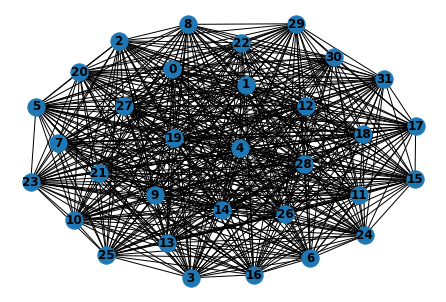

In [76]:
model.eval()
with torch.no_grad():
    preds = model(docs, offsets, labels_list)
    preds = torch.sigmoid(preds)

In [77]:
model.F

tensor([[ 0.0456,  0.1063,  0.0040,  ..., -0.0231, -0.0236,  0.0201],
        [ 0.0483,  0.0993, -0.0055,  ..., -0.0173, -0.0130,  0.0102],
        [ 0.0443,  0.1111, -0.0048,  ..., -0.0236, -0.0285,  0.0195],
        ...,
        [ 0.0476,  0.0810, -0.0150,  ...,  0.0026,  0.0035,  0.0171],
        [ 0.0439,  0.1047, -0.0037,  ..., -0.0202, -0.0266,  0.0222],
        [ 0.0465,  0.1000, -0.0068,  ..., -0.0130, -0.0138,  0.0161]])

In [78]:
model.C

array([[1.        , 0.98811805, 0.99799705, ..., 0.8992417 , 0.99870414,
        0.992489  ],
       [0.98811805, 1.        , 0.98598266, ..., 0.94552314, 0.98946255,
        0.9967897 ],
       [0.99799705, 0.98598266, 1.        , ..., 0.8893988 , 0.9987274 ,
        0.9895275 ],
       ...,
       [0.8992417 , 0.94552314, 0.8893988 , ..., 1.        , 0.8993535 ,
        0.9404258 ],
       [0.99870414, 0.98946255, 0.9987274 , ..., 0.8993535 , 1.        ,
        0.9922061 ],
       [0.992489  , 0.9967897 , 0.9895275 , ..., 0.9404258 , 0.9922061 ,
        1.        ]], dtype=float32)

In [79]:
preds = preds.cpu().numpy()
preds = (preds > 0.555).astype(int)
preds = preds.reshape((preds.shape[0], -1))
preds_list = np.split(preds, offsets[1:-1], axis=1)
preds_list = [row.reshape(-1).tolist() for row in preds_list]

In [80]:
preds_list

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]]

## ROUGE Metric Implementation

### 1) save summary results

In [23]:
import os

In [25]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [26]:
summary_path = './results/summ'
gold_path = './results/gold'

if not os.path.exists(summary_path):
    os.mkdir(summary_path)

if not os.path.exists(gold_path):
    gold_exist = False
    os.mkdir(gold_path)
else:
    gold_exist = True

In [27]:
r_idx = 0
rouge_scores = []
for doc, preds, labels in zip(docs, preds_list, labels_list):
    summ, gold = [], []
    for sent, pred, label in zip(doc, preds, labels):
        if pred == 1:
            summ.append(sent)
        elif label == 1:
            gold.append(sent)
    
    summ = ' '.join(summ)
    gold = ' '.join(gold)
    
    # write files
    with open(f'{summary_path}/test_summ_{r_idx}.txt', 'w', encoding='utf8') as f:
        f.write(summ)
    with open(f'{gold_path}/gold_summ_{r_idx}.txt', 'w', encoding='utf8') as f:
        f.write(gold)
    
    # rouge score append
    rouge_scores.append(scorer.score(gold, summ))
    
    r_idx += 1

In [28]:
summ

"lily allen is the latest famous face to be admitted to hospital but still manage to summon the strength to tweet a selfie from her sick bed exhausted from a heavy week of trans - atlantic partying last night the make - up free star posted a photo of her in a hospital bed with a drip in her arm on twitter writing : ' # sheezus in # shospital i 'm fine though guys , just need some fluids cause i ca n't keep anything down ' the 29 - year - old is following in a long line of celebrities such as miley cyrus , sam faiers and lauren goodger that feel duty bound to keep their followers updated , even when lying in a hospital bed"

In [29]:
gold

"on tuesday she attended miley cyrus ' concert at the 02 in london just 24 hours prior to the concert the singer had been in new york attending the met gala in a chanel dress with a host of a-list stars despite not leaving the met gala party until late , lily allen managed to make it back to london in time to catch twerking star miley cyrus that evening wednesday may 7 : the 29 - year - old singer looks to have dressed to impress for an evening out at nightspot the chiltern firehouse in the capital as she stood out in a dazzling outfit which was covered in black , red and white stars wednesday may 7 : lily allen appears on alan carr : chatty man wednesday may 7 : the singer appears on chat show ' loose women ' before she changes her clothes and heads out on the town in the run up to the weekend the mother - of - two was spotted enjoying herself at the chanel vip chanel , in london , last thursday despite being the life and soul of the parties on thursday , lily allen had also been out 

In [30]:
rouge_scores

[{'rouge1': Score(precision=0.6101694915254238, recall=0.13186813186813187, fmeasure=0.21686746987951808),
  'rouge2': Score(precision=0.27350427350427353, recall=0.05871559633027523, fmeasure=0.09667673716012086),
  'rougeL': Score(precision=0.3220338983050847, recall=0.0695970695970696, fmeasure=0.1144578313253012)}]